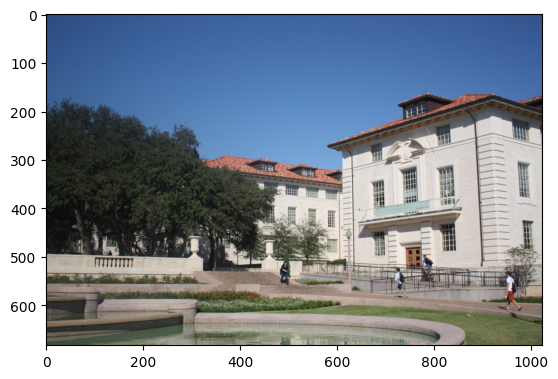

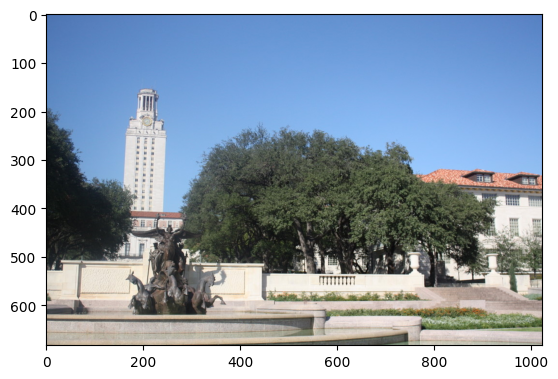

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

img1 = cv2.imread('images/1.jpg')
img2 = cv2.imread('images/2.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()


In [19]:
window_name = 'Image Correspondences'
correspondences = []

def mouse_callback(event, x, y, flags, param):
    global correspondences
    if event == cv2.EVENT_LBUTTONDOWN:
        correspondences.append((x, y))
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow(window_name, img)
        print(f"Point selected: ({x}, {y})")


cv2.imshow(window_name, img1)
img = img1.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points1 = np.array(correspondences)
correspondences = []

cv2.imshow(window_name, img2)
img = img2.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points2 = np.array(correspondences)

cv2.destroyAllWindows()

print(points1)
print(points2)    

Point selected: (178, 507)
Point selected: (104, 504)
Point selected: (444, 297)
Point selected: (531, 311)
Point selected: (636, 544)
Point selected: (567, 544)
Point selected: (890, 322)
Point selected: (984, 328)
[[178 507]
 [104 504]
 [444 297]
 [531 311]]
[[636 544]
 [567 544]
 [890 322]
 [984 328]]


In [59]:
def get_homography_matrix(points1, points2):
    A = np.zeros((8, 9))
    for i in range(4):
        x, y = points1[i]
        u, v = points2[i]
        A[2*i] = [-x, -y, -1, 0, 0, 0, u*x, u*y, u]
        A[2*i+1] = [0, 0, 0, -x, -y, -1, v*x, v*y, v]

    U, S, V = np.linalg.svd(A)
    H = V[-1].reshape((3, 3))
    H /= H[2, 2]
    H[2, 2] = 1
    return H
    

h=get_homography_matrix(points1, points2)
print(h)
print("--------------")
homogeneous_point = np.array([points1[0][0], points1[0][1], 1])
homogeneous_point = homogeneous_point.reshape((3, 1))
print(homogeneous_point)
print(h.shape)
print(homogeneous_point.shape)
x= np.dot(h, homogeneous_point)
x=x/x[2]
print("-----------------")
print(x)
print(points2[0])


[[ 7.50949097e-01 -1.76842070e-03  4.59411786e+02]
 [-1.47432695e-01  8.60237818e-01  9.66247257e+01]
 [-2.04307595e-04 -6.41540761e-05  1.00000000e+00]]
--------------
[[178]
 [507]
 [  1]]
(3, 3)
(3, 1)
-----------------
[[636.]
 [544.]
 [  1.]]
[636 544]


[[ 7.50949097e-01 -1.76842070e-03  4.59411786e+02]
 [-1.47432695e-01  8.60237818e-01  9.66247257e+01]
 [-2.04307595e-04 -6.41540761e-05  1.00000000e+00]]


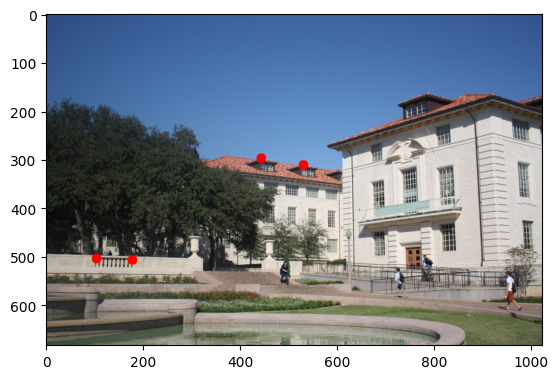

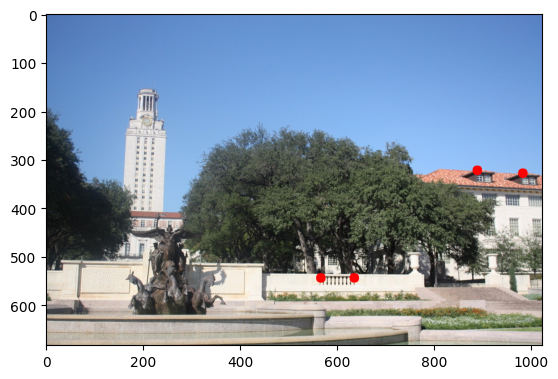

In [492]:
mypoints1 = np.array([[178, 507], [104, 504], [444, 297], [531, 311]])

mypoints2 = np.array([[636, 544], [567, 544], [890, 322], [984, 328]])

myhomography=get_homography_matrix(mypoints1, mypoints2)

print(myhomography)

def show_points(img, points):
    img_copy = img.copy()
    for point in points:
        cv2.circle(img_copy, tuple(point), 10, (255, 0, 0), -1)
    plt.imshow(img_copy)
    plt.show()

show_points(img1, mypoints1)
show_points(img2, mypoints2)



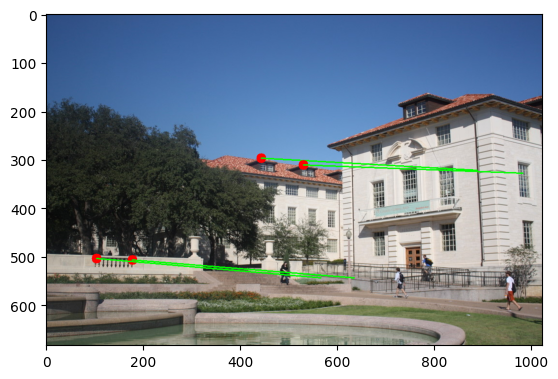

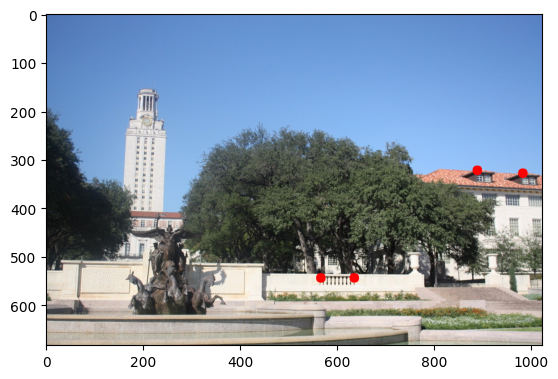

In [493]:
def show_points_correspondence(img1, img2, points1, points2, H):
    img1_copy = img1.copy()
    img2_copy = img2.copy()
    for i in range(4):
        x, y = points1[i]
        u, v = points2[i]
        cv2.circle(img1_copy, tuple(points1[i]), 10, (255, 0, 0), -1)
        cv2.circle(img2_copy, tuple(points2[i]), 10, (255, 0, 0), -1)
        cv2.line(img1_copy, tuple(points1[i]), tuple(points2[i]), (0, 255, 0), 2)
    plt.imshow(img1_copy)
    plt.show()

    plt.imshow(img2_copy)
    plt.show()


show_points_correspondence(img1, img2, mypoints1, mypoints2, myhomography)

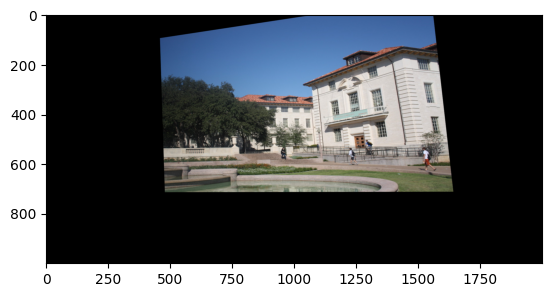

In [497]:
warped_img = cv2.warpPerspective(img1, myhomography, (2000,1000))
plt.imshow(warped_img)
plt.show()


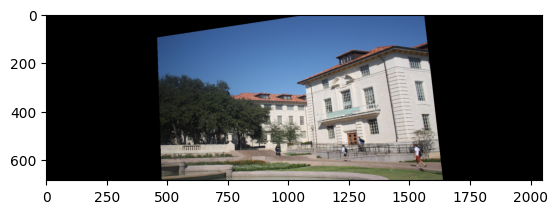

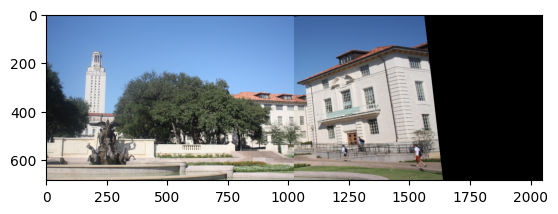

In [37]:
def print_img(img , title = None):
  plt.imshow(img, cmap = plt.get_cmap(None))
  plt.show()
  plt.close()
  print()
  return
def warp(img, H):
  ret = np.zeros((img.shape[0], img.shape[1]*2, 3, 2))
  ret_img = np.zeros((img.shape[0], img.shape[1]*2, 3))
  shape = img.shape
  for i in range(shape[0]):
    for j in range(shape[1]):
      pt = np.array([(i, j, 1)]).T
      pos = H.dot(pt)
      x, y = pos[0] / pos[2], pos[1] / pos[2]
      arr = np.reshape(np.array([(np.floor(x), np.floor(x), np.ceil(x), np.ceil(x)),
                      (np.floor(y), np.ceil(y), np.floor(y), np.ceil(y))]), (2, 4)).T
      arr = np.unique(arr, axis = 0)
      for k in range(len(arr)):
        x, y = int(arr[k][0]), int(arr[k][1])
        if x >= 0 and y >= 0 and x < ret.shape[0] and y < ret.shape[1]:
          for col in range(3):
            ret[x][y][col][0] += 1
            ret[x][y][col][1] += img[i][j][col] 
  
  for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
      for k in range(ret.shape[2]):
        if ret[i][j][k][0] > 0:
          ret_img[i][j][k] = np.round(ret[i][j][k][1]/ret[i][j][k][0]).astype(int)
  return ret_img

dst = warp(img1, h).astype(int)
plt.imshow(dst)
plt.show()
dst[0:img2.shape[0], 0:img2.shape[1]] = img2
print_img(dst, title = 'Final output')

In [ ]:
# save the final image
cv2.imwrite('output.jpg', cv2.cvtColor(dst, cv2.COLOR_RGB2BGR))


### BONUS


(683, 1024, 3)
(683, 1024, 3)
(683, 1024, 3)


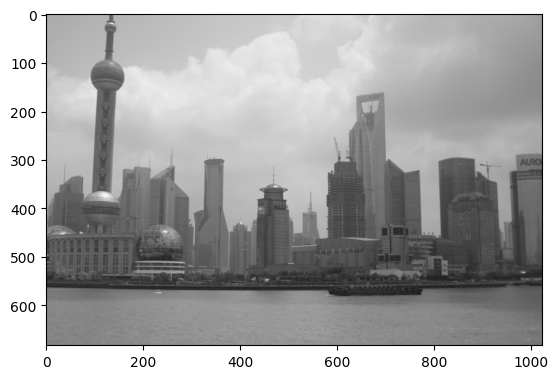

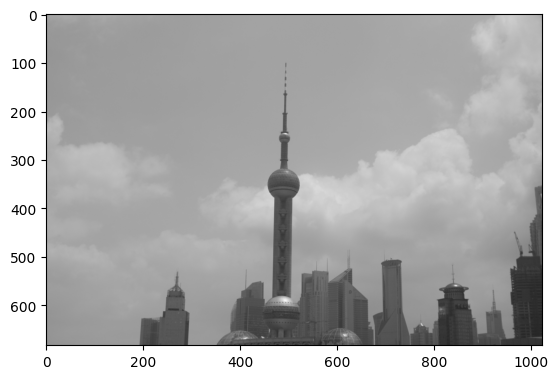

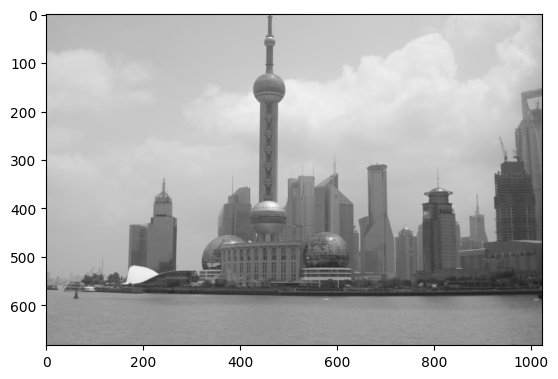

In [160]:
img5 = cv2.imread('images/3.png')
img4 = cv2.imread('images/4.png')
img3 = cv2.imread('images/5.png')

print(img3.shape)
print(img4.shape)
print(img5.shape)

plt.imshow(img3)
plt.show()

plt.imshow(img4)
plt.show()

plt.imshow(img5)
plt.show()

In [134]:
window_name = 'Image Correspondences'
correspondences = []

def mouse_callback(event, x, y, flags, param):
    global correspondences
    if event == cv2.EVENT_LBUTTONDOWN:
        correspondences.append((x, y))
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow(window_name, img)
        print(f"Point selected: ({x}, {y})")


cv2.imshow(window_name, img3)
img = img3.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points3 = np.array(correspondences)
correspondences = []

cv2.imshow(window_name, img5)
img = img5.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points5 = np.array(correspondences)

cv2.destroyAllWindows()

print(points3)
print(points5)    

Point selected: (643, 171)
Point selected: (305, 413)
Point selected: (181, 455)
Point selected: (8, 460)
Point selected: (983, 163)
Point selected: (645, 426)
Point selected: (524, 472)
Point selected: (361, 480)
[[643 171]
 [305 413]
 [181 455]
 [  8 460]]
[[983 163]
 [645 426]
 [524 472]
 [361 480]]


In [135]:

h=get_homography_matrix(points3, points5)
print(h)
print("--------------")
homogeneous_point = np.array([points3[0][0], points3[0][1], 1])
homogeneous_point = homogeneous_point.reshape((3, 1))
print(homogeneous_point)
print(h.shape)
print(homogeneous_point.shape)
x= np.dot(h, homogeneous_point)
x=x/x[2]
print("-----------------")
print(x)
x=x.astype(int)
print(x)
print(points5[0])


[[ 8.34122283e-01 -6.56627152e-02  3.66573573e+02]
 [-7.10465761e-02  9.10550053e-01  3.78372800e+01]
 [-1.16246486e-04 -1.06121748e-04  1.00000000e+00]]
--------------
[[643]
 [171]
 [  1]]
(3, 3)
(3, 1)
-----------------
[[983.]
 [163.]
 [  1.]]
[[983]
 [163]
 [  1]]
[983 163]


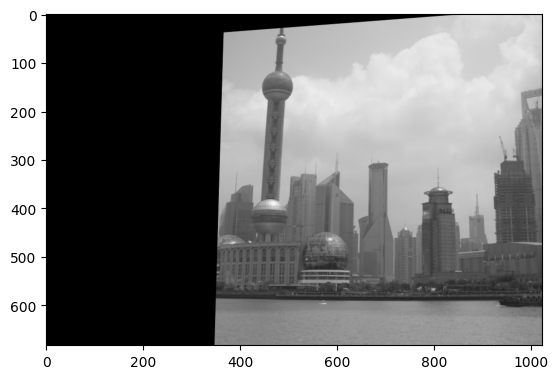

In [137]:
warped_img2 = cv2.warpPerspective(img3, h, (img3.shape[1], img3.shape[0]))
plt.imshow(warped_img2)
plt.show()

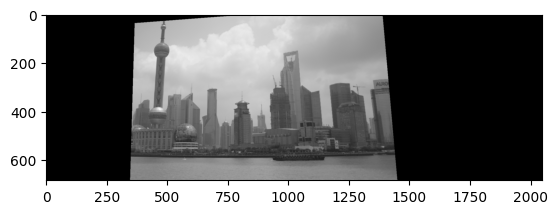

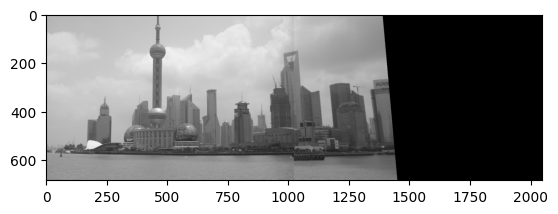

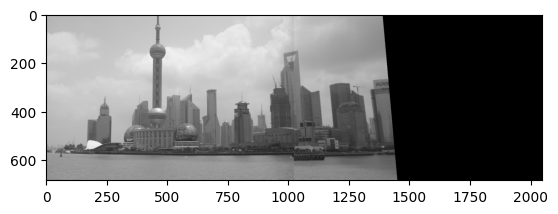

In [138]:
dst = warp(img3, h).astype(int)
plt.imshow(dst)
plt.show()
dst[0:img5.shape[0], 0:img5.shape[1]] = img5
print_img(dst, title = 'Final output')


matrix=dst.copy()
for i in range(img5.shape[0]):
  for j in range(img5.shape[1]):
    if np.all(matrix[i][j]==0):
      matrix[i][j]=img5[i][j]
    else:
      matrix[i][j]=dst[i][j]

plt.imshow(matrix)
plt.show()


In [139]:
# save as png and name it panorama1.png
cv2.imwrite('panorama1.png', matrix)


True

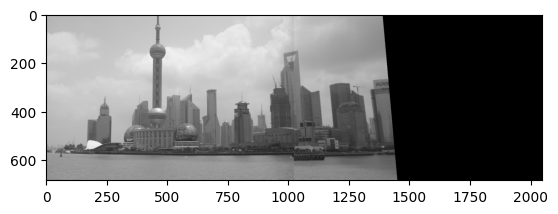

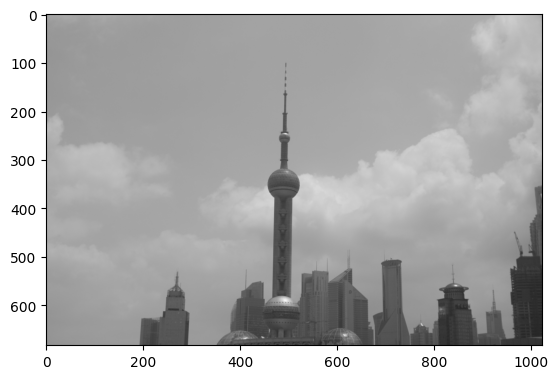

In [144]:
# load panorama1.png
img6 = cv2.imread('panorama1.png')
plt.imshow(img6)
plt.show()

plt.imshow(img4)
plt.show()


In [371]:
window_name = 'Image Correspondences'
correspondences = []

def mouse_callback(event, x, y, flags, param):
    global correspondences
    if event == cv2.EVENT_LBUTTONDOWN:
        correspondences.append((x, y))
        cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
        cv2.imshow(window_name, img)
        print(f"Point selected: ({x}, {y})")


cv2.imshow(window_name, img4)
img = img4.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points4 = np.array(correspondences)
correspondences = []

cv2.imshow(window_name, img6)
img = img6.copy()
cv2.setMouseCallback(window_name, mouse_callback)
cv2.waitKey(0)

points6 = np.array(correspondences)

cv2.destroyAllWindows()

print(points4)
print(points6)    

Point selected: (664, 591)
Point selected: (553, 668)
Point selected: (292, 613)
Point selected: (270, 533)
Point selected: (635, 392)
Point selected: (526, 469)
Point selected: (266, 421)
Point selected: (244, 342)
[[664 591]
 [553 668]
 [292 613]
 [270 533]]
[[635 392]
 [526 469]
 [266 421]
 [244 342]]


In [372]:
h=get_homography_matrix(points6, points4)
print(h)
print("--------------")
homogeneous_point = np.array([points6[0][0], points6[0][1], 1])
homogeneous_point = homogeneous_point.reshape((3, 1))
print(homogeneous_point)
print(h.shape)
print(homogeneous_point.shape)
x= np.dot(h, homogeneous_point)
x=x/x[2]
print("-----------------")
print(x)
x=x.astype(int)
print(x)
print(points4[0])

[[ 9.39530390e-01 -1.24676536e-03  3.49052201e+01]
 [-1.91046437e-02  9.70060307e-01  1.93512096e+02]
 [-6.48121171e-05 -2.17233718e-05  1.00000000e+00]]
--------------
[[635]
 [392]
 [  1]]
(3, 3)
(3, 1)
-----------------
[[664.]
 [591.]
 [  1.]]
[[663]
 [590]
 [  1]]
[664 591]


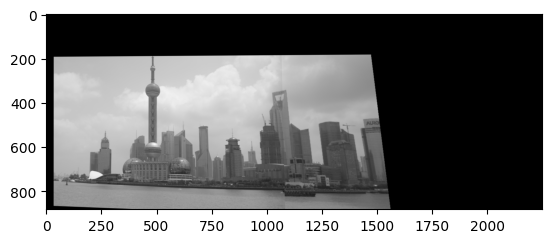

In [373]:
warped_img2 = cv2.warpPerspective(img6, h, (img6.shape[1]+200, img6.shape[0]+200))
plt.imshow(warped_img2)
plt.show()

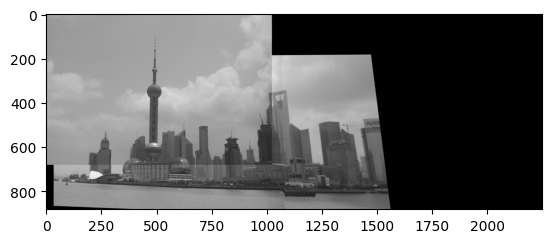

(883, 2248, 3)


In [383]:
warped_img2[0:img4.shape[0], 0:img4.shape[1]] = img4
plt.imshow(warped_img2)
plt.show()
print(warped_img2.shape)

In [463]:
def warp2(img, H):
  ret = np.zeros((img.shape[0]*2, img.shape[1]*2, 3, 2))
  ret_img = np.zeros((img.shape[0]*2, img.shape[1]*2, 3))
  # ret = np.zeros((883, 2248, 3, 2))
  # ret_img = np.zeros((883, 2248, 3))  
  shape = img.shape
  for i in range(shape[0]):
    for j in range(shape[1]):
      if 1==True:
        pt = np.array([(i, j, 1)]).T
        pos = H.dot(pt)
        x, y = pos[0] / pos[2], pos[1] / pos[2]
        arr = np.reshape(np.array([(np.floor(x), np.floor(x), np.ceil(x), np.ceil(x)),
                        (np.floor(y), np.ceil(y), np.floor(y), np.ceil(y))]), (2, 4)).T
        arr = np.unique(arr, axis = 0)
        for k in range(len(arr)):
          x, y = int(arr[k][0]), int(arr[k][1])
          if x >= 0 and y >= 0 and x < ret.shape[0] and y < ret.shape[1]:
            for col in range(3):
              ret[x][y][col][0] += 1
              ret[x][y][col][1] += img[i][j][col] 
  
  for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
      for k in range(ret.shape[2]):
        if ret[i][j][k][0] > 0:
          ret_img[i][j][k] = np.round(ret[i][j][k][1]/ret[i][j][k][0]).astype(int)
  return ret_img

In [486]:

def warp3(img, H):
  ret = np.zeros((img.shape[0], img.shape[1]*2, 3, 2))
  ret_img = np.zeros((img.shape[0], img.shape[1]*2, 3))
  shape = img.shape
  for i in range(shape[0]):
    for j in range(shape[1]):
      pt = np.array([(i, j, 1)]).T
      pos = H.dot(pt)
      x, y = pos[0] / pos[2], pos[1] / pos[2]
      arr = np.reshape(np.array([(np.floor(x), np.floor(x), np.ceil(x), np.ceil(x)),
                      (np.floor(y), np.ceil(y), np.floor(y), np.ceil(y))]), (2, 4)).T
      arr = np.unique(arr, axis = 0)
      for k in range(len(arr)):
        x, y = int(arr[k][0]), int(arr[k][1])
        if x >= 0 and y >= 0 and x < ret.shape[0] and y < ret.shape[1]:
          for col in range(3):
            ret[x][y][col][0] += 1
            ret[x][y][col][1] += img[i][j][col] 
  
  for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
      for k in range(ret.shape[2]):
        if ret[i][j][k][0] > 0:
          ret_img[i][j][k] = np.round(ret[i][j][k][1]/ret[i][j][k][0]).astype(int)
  return ret_img

def warp4(img, H):
  ret = np.zeros((img.shape[0], img.shape[1]*2, 3, 2))
  ret_img = np.zeros((img.shape[0], img.shape[1]*2, 3))
  shape = img.shape
  for i in range(shape[0]):
    for j in range(shape[1]):
      pt = np.array([(i, j, 1)]).T
      pos = H.dot(pt)
      x, y = pos[0] / pos[2], pos[1] / pos[2]
      arr = np.reshape(np.array([(np.floor(x), np.floor(x), np.ceil(x), np.ceil(x)),
                      (np.floor(y), np.ceil(y), np.floor(y), np.ceil(y))]), (2, 4)).T
      arr = np.unique(arr, axis = 0)
      for k in range(len(arr)):
        x, y = int(arr[k][0]), int(arr[k][1])
        if x >= 0 and y >= 0 and x < ret.shape[0] and y < ret.shape[1]:
          for col in range(3):
            ret[x][y][col][0] += 1
            ret[x][y][col][1] += img[i][j][col] 
  
  for i in range(ret.shape[0]):
    for j in range(ret.shape[1]):
      for k in range(ret.shape[2]):
        if ret[i][j][k][0] > 0:
          ret_img[i][j][k] = np.round(ret[i][j][k][1]/ret[i][j][k][0]).astype(int)
  return ret_img

In [415]:
print(dst.shape)
print(img4.shape)
print(img6.shape)

(883, 2248, 3)
(683, 1024, 3)
(683, 2048, 3)
